# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install --q torchsummary

# Custom_Resnet

In [3]:
import torch.nn.functional as F

# Define a ResNet block with Group normalization
class MyResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.GroupNorm(4, out_channels)  # Group normalization with 4 groups
        self.activation1 = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.GroupNorm(4, out_channels)  # Group normalization with 4 groups

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += shortcut
        x = self.activation1(x)
        return x

# Define the main ResNet model with Group normalization
class MyResNet(nn.Module):
    def __init__(self):
        super(MyResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.GroupNorm(32, 32)  # Group normalization with 4 groups
        self.activation1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.GroupNorm(32, 64)  # Group normalization with 4 groups
        self.activation2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.resblock1 = MyResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.GroupNorm(32, 128)  # Group normalization with 4 groups
        self.activation3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.GroupNorm(32, 256)  # Group normalization with 4 groups
        self.activation4 = nn.ELU()
        self.resblock2 = MyResNetBlock(256, 256)

        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256, 256)
        self.dense2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        x = self.maxpool1(x)

        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation3(x)
        x = self.maxpool2(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.activation4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x


In [4]:
from torchsummary import summary

# Instantiate the model
model = MyResNet()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         GroupNorm-2           [-1, 32, 32, 32]              64
               ELU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
         GroupNorm-5           [-1, 64, 32, 32]             128
               ELU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
         GroupNorm-9           [-1, 64, 16, 16]             128
              ELU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
        GroupNorm-12           [-1, 64, 16, 16]             128
              ELU-13           [-1, 64, 16, 16]               0
    MyResNetBlock-14           [-1, 64,

# Dataset

In [5]:
# Data augmentation transformations for training data
data_augmentation_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by 15 degrees
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor values
])

# Data preprocessing transformations for test/validation data
data_preprocessing_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the tensor values
])


# Load CIFAR-10 dataset
# Training set with data augmentation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_augmentation_train)
# Test set with data preprocessing
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_preprocessing_test)

# Splitting the training dataset into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 128
# Training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 29582571.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Training

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyResNet().to(device)

In [7]:
# Optimizer, Learning Rate Scheduler, and Loss Criterion
# Stochastic Gradient Descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Learning rate scheduler with step decay
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
# CrossEntropyLoss criterion for classification tasks
criterion = nn.CrossEntropyLoss()

In [8]:
from tqdm import tqdm

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
best_model_weights = None

# Number of epochs
epochs = 100

# Training loop
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += data.size(0)

        total_loss += loss.item()

    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy_train = correct / total_samples

    print(f'Train Epoch: {epoch}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy_train:.2}')

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy_val = correct / len(val_loader.dataset)
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {accuracy_val:.2f}')

    # Append values for plotting
    train_losses.append(average_loss)
    train_accuracies.append(accuracy_train)

    # Append values for plotting
    val_losses.append(val_loss)
    val_accuracies.append(accuracy_val)

    if accuracy_val > best_val_accuracy:
       best_val_accuracy = accuracy_val
       best_model_weights = model.state_dict()

    scheduler.step()

100%|██████████| 352/352 [00:34<00:00, 10.19it/s]


Train Epoch: 1, Average Loss: 0.0171, Accuracy: 0.26
Validation set: Average loss: 0.0166, Accuracy: 0.38


100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Train Epoch: 2, Average Loss: 0.0161, Accuracy: 0.4
Validation set: Average loss: 0.0161, Accuracy: 0.45


100%|██████████| 352/352 [00:30<00:00, 11.52it/s]


Train Epoch: 3, Average Loss: 0.0156, Accuracy: 0.47
Validation set: Average loss: 0.0159, Accuracy: 0.48


100%|██████████| 352/352 [00:29<00:00, 11.89it/s]


Train Epoch: 4, Average Loss: 0.0153, Accuracy: 0.5
Validation set: Average loss: 0.0156, Accuracy: 0.51


100%|██████████| 352/352 [00:30<00:00, 11.52it/s]


Train Epoch: 5, Average Loss: 0.0151, Accuracy: 0.53
Validation set: Average loss: 0.0155, Accuracy: 0.53


100%|██████████| 352/352 [00:31<00:00, 11.12it/s]


Train Epoch: 6, Average Loss: 0.0150, Accuracy: 0.54
Validation set: Average loss: 0.0153, Accuracy: 0.55


100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Train Epoch: 7, Average Loss: 0.0149, Accuracy: 0.55
Validation set: Average loss: 0.0154, Accuracy: 0.54


100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Train Epoch: 8, Average Loss: 0.0148, Accuracy: 0.57
Validation set: Average loss: 0.0154, Accuracy: 0.53


100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Train Epoch: 9, Average Loss: 0.0148, Accuracy: 0.57
Validation set: Average loss: 0.0154, Accuracy: 0.54


100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Train Epoch: 10, Average Loss: 0.0147, Accuracy: 0.59
Validation set: Average loss: 0.0152, Accuracy: 0.56


100%|██████████| 352/352 [00:29<00:00, 11.88it/s]


Train Epoch: 11, Average Loss: 0.0146, Accuracy: 0.59
Validation set: Average loss: 0.0151, Accuracy: 0.58


100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Train Epoch: 12, Average Loss: 0.0145, Accuracy: 0.61
Validation set: Average loss: 0.0149, Accuracy: 0.60


100%|██████████| 352/352 [00:29<00:00, 11.76it/s]


Train Epoch: 13, Average Loss: 0.0144, Accuracy: 0.62
Validation set: Average loss: 0.0147, Accuracy: 0.63


100%|██████████| 352/352 [00:29<00:00, 11.92it/s]


Train Epoch: 14, Average Loss: 0.0144, Accuracy: 0.63
Validation set: Average loss: 0.0149, Accuracy: 0.60


100%|██████████| 352/352 [00:29<00:00, 11.92it/s]


Train Epoch: 15, Average Loss: 0.0143, Accuracy: 0.63
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:30<00:00, 11.49it/s]


Train Epoch: 16, Average Loss: 0.0142, Accuracy: 0.65
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:29<00:00, 12.09it/s]


Train Epoch: 17, Average Loss: 0.0142, Accuracy: 0.64
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Train Epoch: 18, Average Loss: 0.0142, Accuracy: 0.65
Validation set: Average loss: 0.0145, Accuracy: 0.64


100%|██████████| 352/352 [00:30<00:00, 11.73it/s]


Train Epoch: 19, Average Loss: 0.0141, Accuracy: 0.66
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Train Epoch: 20, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Train Epoch: 21, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:29<00:00, 11.91it/s]


Train Epoch: 22, Average Loss: 0.0140, Accuracy: 0.68
Validation set: Average loss: 0.0144, Accuracy: 0.66


100%|██████████| 352/352 [00:29<00:00, 11.85it/s]


Train Epoch: 23, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0146, Accuracy: 0.64


100%|██████████| 352/352 [00:30<00:00, 11.71it/s]


Train Epoch: 24, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0144, Accuracy: 0.67


100%|██████████| 352/352 [00:29<00:00, 11.86it/s]


Train Epoch: 25, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0142, Accuracy: 0.68


100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Train Epoch: 26, Average Loss: 0.0138, Accuracy: 0.69
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:30<00:00, 11.45it/s]


Train Epoch: 27, Average Loss: 0.0138, Accuracy: 0.69
Validation set: Average loss: 0.0144, Accuracy: 0.66


100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Train Epoch: 28, Average Loss: 0.0138, Accuracy: 0.7
Validation set: Average loss: 0.0142, Accuracy: 0.69


100%|██████████| 352/352 [00:29<00:00, 11.90it/s]


Train Epoch: 29, Average Loss: 0.0137, Accuracy: 0.7
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:29<00:00, 11.92it/s]


Train Epoch: 30, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0144, Accuracy: 0.66


100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Train Epoch: 31, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0142, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.66it/s]


Train Epoch: 32, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0141, Accuracy: 0.71


100%|██████████| 352/352 [00:29<00:00, 11.87it/s]


Train Epoch: 33, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:29<00:00, 11.80it/s]


Train Epoch: 34, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0141, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Train Epoch: 35, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0140, Accuracy: 0.72


100%|██████████| 352/352 [00:29<00:00, 11.92it/s]


Train Epoch: 36, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.73it/s]


Train Epoch: 37, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:29<00:00, 11.89it/s]


Train Epoch: 38, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:29<00:00, 11.87it/s]


Train Epoch: 39, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.65it/s]


Train Epoch: 40, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Train Epoch: 41, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:29<00:00, 11.83it/s]


Train Epoch: 42, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:29<00:00, 11.74it/s]


Train Epoch: 43, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.87it/s]


Train Epoch: 44, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.72


100%|██████████| 352/352 [00:29<00:00, 11.87it/s]


Train Epoch: 45, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.03it/s]


Train Epoch: 46, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.91it/s]


Train Epoch: 47, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0138, Accuracy: 0.73


100%|██████████| 352/352 [00:30<00:00, 11.68it/s]


Train Epoch: 48, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0138, Accuracy: 0.74


100%|██████████| 352/352 [00:29<00:00, 11.99it/s]


Train Epoch: 49, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:29<00:00, 11.87it/s]


Train Epoch: 50, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Train Epoch: 51, Average Loss: 0.0131, Accuracy: 0.79
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:29<00:00, 11.91it/s]


Train Epoch: 52, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:30<00:00, 11.54it/s]


Train Epoch: 53, Average Loss: 0.0130, Accuracy: 0.79
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Train Epoch: 54, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0135, Accuracy: 0.77


100%|██████████| 352/352 [00:29<00:00, 11.88it/s]


Train Epoch: 55, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Train Epoch: 56, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0135, Accuracy: 0.77


100%|██████████| 352/352 [00:29<00:00, 11.79it/s]


Train Epoch: 57, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0135, Accuracy: 0.77


100%|██████████| 352/352 [00:29<00:00, 11.78it/s]


Train Epoch: 58, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Train Epoch: 59, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0135, Accuracy: 0.77


100%|██████████| 352/352 [00:30<00:00, 11.73it/s]


Train Epoch: 60, Average Loss: 0.0130, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:30<00:00, 11.59it/s]


Train Epoch: 61, Average Loss: 0.0130, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.88it/s]


Train Epoch: 62, Average Loss: 0.0130, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.90it/s]


Train Epoch: 63, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.77it/s]


Train Epoch: 64, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.85it/s]


Train Epoch: 65, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.86it/s]


Train Epoch: 66, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.90it/s]


Train Epoch: 67, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.81it/s]


Train Epoch: 68, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:30<00:00, 11.65it/s]


Train Epoch: 69, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.86it/s]


Train Epoch: 70, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.86it/s]


Train Epoch: 71, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.77


100%|██████████| 352/352 [00:29<00:00, 11.84it/s]


Train Epoch: 72, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Train Epoch: 73, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.83it/s]


Train Epoch: 74, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.93it/s]


Train Epoch: 75, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.90it/s]


Train Epoch: 76, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:30<00:00, 11.60it/s]


Train Epoch: 77, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.77


100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Train Epoch: 78, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.80it/s]


Train Epoch: 79, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.80it/s]


Train Epoch: 80, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.80it/s]


Train Epoch: 81, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.79


100%|██████████| 352/352 [00:30<00:00, 11.52it/s]


Train Epoch: 82, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Train Epoch: 83, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 12.06it/s]


Train Epoch: 84, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:30<00:00, 11.65it/s]


Train Epoch: 85, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Train Epoch: 86, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.91it/s]


Train Epoch: 87, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.95it/s]


Train Epoch: 88, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 12.09it/s]


Train Epoch: 89, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Train Epoch: 90, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 12.00it/s]


Train Epoch: 91, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.97it/s]


Train Epoch: 92, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.86it/s]


Train Epoch: 93, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.88it/s]


Train Epoch: 94, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:29<00:00, 11.88it/s]


Train Epoch: 95, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:30<00:00, 11.66it/s]


Train Epoch: 96, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.92it/s]


Train Epoch: 97, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.94it/s]


Train Epoch: 98, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.83it/s]


Train Epoch: 99, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.79


100%|██████████| 352/352 [00:29<00:00, 11.88it/s]


Train Epoch: 100, Average Loss: 0.0128, Accuracy: 0.83
Validation set: Average loss: 0.0134, Accuracy: 0.78


In [9]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}')

Test set: Average loss: 0.0132, Accuracy: 0.80


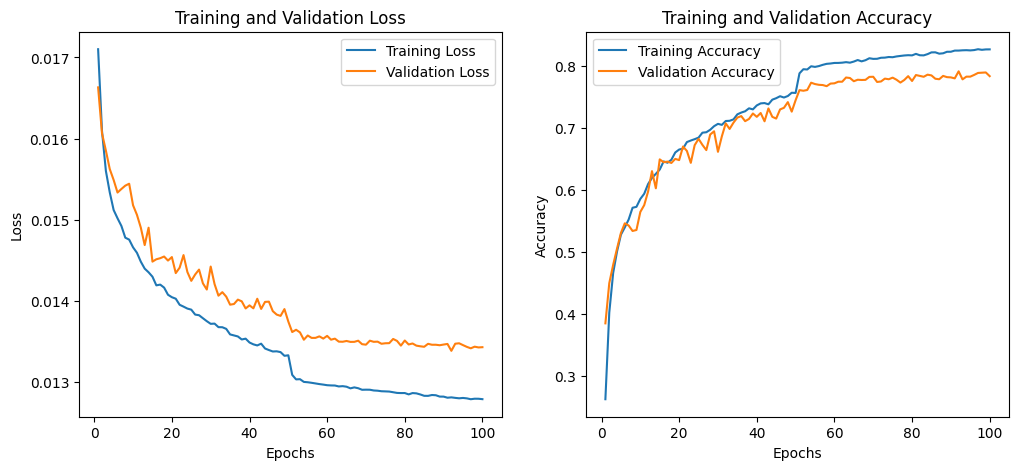

In [10]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [11]:
torch.save(model.state_dict(), 'trained_MyResNet_GN.pth')

# Metrics

In [4]:
!git clone https://github.com/K-Hooshanfar/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 800.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex
import torch
from tqdm import tqdm

In [5]:
# Load the pre-trained model
state_dict = torch.load('/content/trained_MyResNet_GN.pth')

model = MyResNet()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Convert test_dataset to a list or NumPy array
test_data_list = [(img, label) for img, label in test_dataset]

# Further split train_dataset into train_loader_dataset and 10% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.1 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Similarly, for the test_loader
test_loader_dataset, _ = train_test_split(test_data_list, train_size=int(0.1 * len(test_dataset)),
                                          test_size=None, shuffle=True, stratify=test_dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_loader_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
features_per_layer = {}
labels = []

# Get the total number of layers in the model
total_layers = len(list(model.children()))

# Exclude the last four layers
layers_to_be_deleted = set(list(model.children())[-4:])

# Attach hooks to each layer except the excluded ones
features_per_layer = {}
for name, layer in model.named_children():
    if layer not in layers_to_be_deleted:
        features_per_layer[name] = []
        def hook(module, input, output, name=name):
            features_per_layer[name].append(output.detach())
        layer.register_forward_hook(hook)

In [9]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 32/32 [00:01<00:00, 21.19it/s]


# SI

In [10]:
si_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 585.39it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3146.04it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3273.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 742.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1399.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1583.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2517.29it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4379.10it/s]

Data has been normalized



Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2484.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4320.46it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3425.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1352.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 556.51it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 648.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1179.50it/s]

Data has been normalized



Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3674.70it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4145.39it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2564.07it/s]


In [11]:
si_train

[('conv1', 0.22592592239379883),
 ('bn1', 0.32543209195137024),
 ('activation1', 0.3338271677494049),
 ('conv2', 0.2893827259540558),
 ('bn2', 0.36320987343788147),
 ('activation2', 0.3708641827106476),
 ('maxpool1', 0.43530863523483276),
 ('resblock1', 0.5162962675094604),
 ('maxpool2', 0.5809876322746277),
 ('conv3', 0.5624691247940063),
 ('bn3', 0.5674074292182922),
 ('activation3', 0.5595061779022217),
 ('maxpool3', 0.6469135880470276),
 ('conv4', 0.6281481385231018),
 ('bn4', 0.6200000047683716),
 ('activation4', 0.6266666650772095),
 ('resblock2', 0.7345678806304932),
 ('avgpool', 0.7580246925354004)]

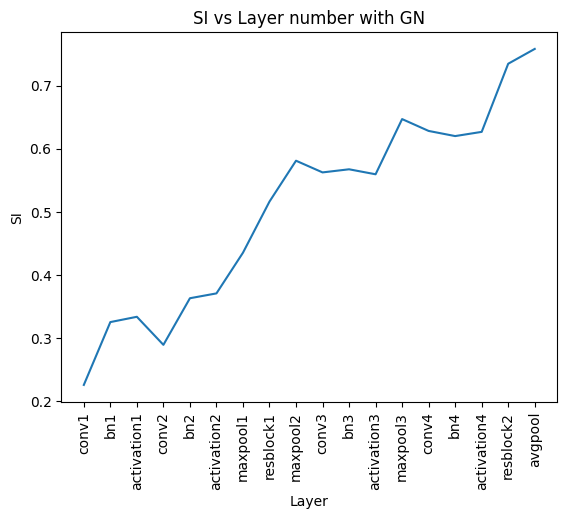

In [12]:
plt.plot([layer for layer, _ in si_train], [si for _, si in si_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number with GN')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [10]:
csi_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1038.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1348.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 891.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 515.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1761.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1245.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1470.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2304.31it/s]

Data has been normalized

Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1256.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1196.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1230.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2151.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 804.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1899.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1322.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1134.39it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3023.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1736.92it/s]


In [11]:
csi_train

[('conv1', 0.35333332419395447),
 ('bn1', 0.3992592692375183),
 ('activation1', 0.41012346744537354),
 ('conv2', 0.42641976475715637),
 ('bn2', 0.431851863861084),
 ('activation2', 0.4570370316505432),
 ('maxpool1', 0.5093827247619629),
 ('resblock1', 0.6207407116889954),
 ('maxpool2', 0.6545678973197937),
 ('conv3', 0.6269136071205139),
 ('bn3', 0.6338271498680115),
 ('activation3', 0.6437036991119385),
 ('maxpool3', 0.7041975259780884),
 ('conv4', 0.6679012179374695),
 ('bn4', 0.6706172823905945),
 ('activation4', 0.6800000071525574),
 ('resblock2', 0.8083950877189636),
 ('avgpool', 0.8325926065444946)]

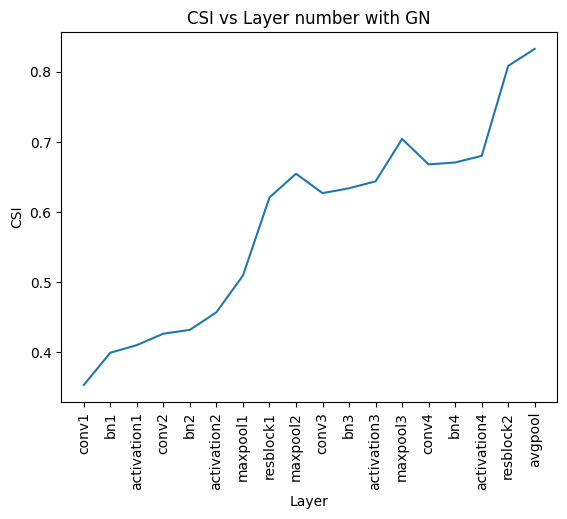

In [12]:
plt.plot([layer for layer, _ in csi_train], [si for _, si in csi_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI vs Layer number with GN')
plt.xticks(rotation=90)
plt.show()

# Metrics of Test Loader

In [9]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 8/8 [00:01<00:00,  4.30it/s]


# SI

In [10]:
si_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1555.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 510.69it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 376.24it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2928.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2441.39it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2718.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2799.94it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3194.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 481.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1006.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3002.37it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2566.89it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 815.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3017.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3194.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3010.99it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 267.75it/s]


In [11]:
si_test

[('conv1', 0.1711111217737198),
 ('bn1', 0.28777778148651123),
 ('activation1', 0.2922222316265106),
 ('conv2', 0.2622222304344177),
 ('bn2', 0.324444442987442),
 ('activation2', 0.3266666829586029),
 ('maxpool1', 0.4000000059604645),
 ('resblock1', 0.4911111295223236),
 ('maxpool2', 0.551111102104187),
 ('conv3', 0.5200000405311584),
 ('bn3', 0.5366666913032532),
 ('activation3', 0.5066666603088379),
 ('maxpool3', 0.6033333539962769),
 ('conv4', 0.5711111426353455),
 ('bn4', 0.5800000429153442),
 ('activation4', 0.5844444632530212),
 ('resblock2', 0.6788889169692993),
 ('avgpool', 0.7066667079925537)]

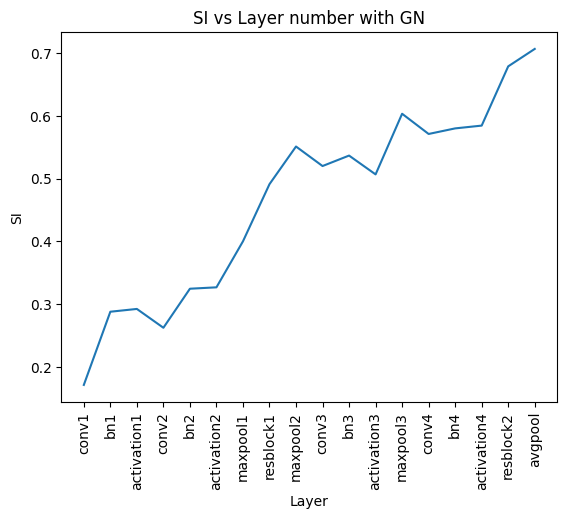

In [17]:
plt.plot([layer for layer, _ in si_test], [si for _, si in si_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number with GN')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [13]:
csi_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 571.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1134.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 621.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1318.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 455.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1445.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1850.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1648.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1199.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 930.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1720.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1604.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1423.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 353.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 907.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 702.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1864.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1485.76it/s]


In [14]:
csi_test

[('conv1', 0.42888888716697693),
 ('bn1', 0.5055555701255798),
 ('activation1', 0.5433333516120911),
 ('conv2', 0.5722222328186035),
 ('bn2', 0.5755555629730225),
 ('activation2', 0.59333336353302),
 ('maxpool1', 0.6388888955116272),
 ('resblock1', 0.7433333396911621),
 ('maxpool2', 0.7433333396911621),
 ('conv3', 0.7277777791023254),
 ('bn3', 0.7377777695655823),
 ('activation3', 0.7599999904632568),
 ('maxpool3', 0.753333330154419),
 ('conv4', 0.7444444894790649),
 ('bn4', 0.746666669845581),
 ('activation4', 0.7511111497879028),
 ('resblock2', 0.7988889217376709),
 ('avgpool', 0.8044444918632507)]

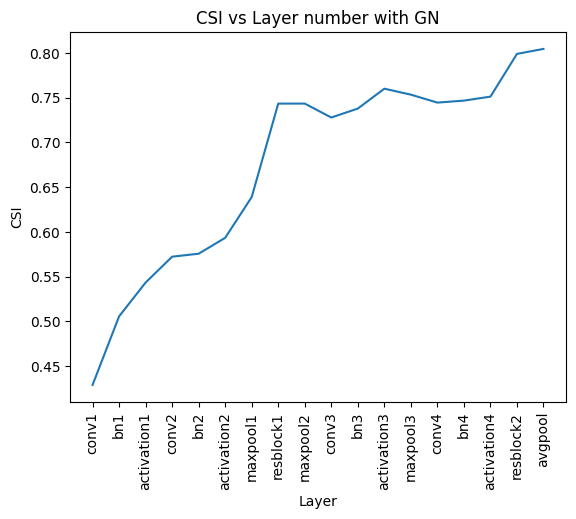

In [16]:
plt.plot([layer for layer, _ in csi_test], [si for _, si in csi_test])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI vs Layer number with GN')
plt.xticks(rotation=90)
plt.show()